# Import Library

In [47]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import numpy as np, tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0



TensorFlow version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Data Importing

In [48]:
def load_data(path):
    with open(path, 'rb') as file:
        return pickle.load(file)

from google.colab import drive
drive.mount('/content/drive')


train_data = load_data('/content/drive/MyDrive/ML_final/Data/train.pickle')
valid_data = load_data('/content/drive/MyDrive/ML_final/Data/valid.pickle')
test_data = load_data('/content/drive/MyDrive/ML_final/Data/test.pickle')

x_train, y_train = train_data['features'], train_data['labels']
x_val, y_val = valid_data['features'], valid_data['labels']
x_test, y_test = test_data['features'], test_data['labels']



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Data Processing

In [49]:
AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = (32, 32)
NUM_CLASSES = 43

In [50]:
# Core preprocessing
def base_preprocess(img):
    """Primary deterministic transforms."""
    img = tf.cast(img, tf.float32) / 255.0          # 2-D min–max normalisation
    img = tf.image.resize(img, IMG_SIZE)           #Ensure 32*32
    return img


In [51]:
# channel-wise standardisation
CHANNEL_MEAN = tf.constant(np.mean(x_train / 255.0, axis=(0,1,2)), dtype=tf.float32)
CHANNEL_STD  = tf.constant(np.std (x_train / 255.0, axis=(0,1,2)), dtype=tf.float32)

def standardise(img):
    img = (img - CHANNEL_MEAN) / (CHANNEL_STD + 1e-7)
    return img

In [52]:
# 1. Build a Keras-only augmentation block
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.10, fill_mode="reflect"),     # ±10%
    tf.keras.layers.RandomTranslation(0.10, 0.10, fill_mode="reflect"),
    tf.keras.layers.RandomContrast(0.25),                          # 25% contrast jitter
])

In [53]:
# Build the tf.data pipeline
def prepare_ds(images, labels, training=False, batch=64):
    ds = tf.data.Dataset.from_tensor_slices((images, labels))
    if training:
        ds = ds.shuffle(10_000)
    ds = ds.map(lambda x, y: (base_preprocess(x), y),
                num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.map(lambda x, y: (data_augmentation(x), y),
                    num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch).prefetch(AUTOTUNE)
    return ds

In [54]:
train_ds = prepare_ds(x_train, y_train, training=True)
val_ds   = prepare_ds(x_val,   y_val)
test_ds  = prepare_ds(x_test,  y_test)

# 5. Sanity-check one batch
imgs, labs = next(iter(train_ds))
print("Batch images:", imgs.shape)
print("Batch labels:", labs.shape)

Batch images: (64, 32, 32, 3)
Batch labels: (64,)


Model- EfficientNetB0

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Build base + custom head
base = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(32, 32, 3)
)
base.trainable = False

x = GlobalAveragePooling2D()(base.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model_ft = Model(inputs=base.input, outputs=outputs)

# compile head-only
model_ft.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)



# recompile with lower learning rate
model_ft.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training (fine-tuning)
history_finetune = model_ft.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    verbose=1
)

# Evaluate on the test set
test_loss, test_acc = model_ft.evaluate(test_ds, verbose=0)
print(f"Fine-tuned EfficientNetB0 Test Accuracy: {test_acc * 100:.2f}%")


Epoch 1/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 85s 121ms/step - accuracy: 0.0833 - loss: 3.6053 - val_accuracy: 0.0544 - val_loss: 3.6467
Epoch 2/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 70s 115ms/step - accuracy: 0.0401 - loss: 3.7008 - val_accuracy: 0.0544 - val_loss: 3.6214
Epoch 3/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 71s 95ms/step - accuracy: 0.0369 - loss: 3.6962 - val_accuracy: 0.0544 - val_loss: 3.6084
Epoch 4/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 40s 74ms/step - accuracy: 0.0364 - loss: 3.6837 - val_accuracy: 0.0544 - val_loss: 3.5956
Epoch 5/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 41s 75ms/step - accuracy: 0.0363 - loss: 3.6735 - val_accuracy: 0.0599 - val_loss: 3.5919
Epoch 6/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 47s 86ms/step - accuracy: 0.0353 - loss: 3.6723 - val_accuracy: 0.0476 - val_loss: 3.5860
Epoch 7/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 41s 75ms/step - accuracy: 0.0369 - loss: 3.6594 - val_accuracy: 0.0544 - val_loss: 3.5851
Epoch 8/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 41s 75ms/step - accuracy: 0.0354 - loss: 3.6547 

Redo the Data agumentation try to improve accuracy

In [55]:
AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = (224, 224)
NUM_CLASSES = 43

# Core preprocessing
def base_preprocess_n(img):
    """Primary deterministic transforms."""
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.image.resize(img, IMG_SIZE)
    return img

# channel-wise standardisation
CHANNEL_MEAN_n = tf.constant(np.mean(x_train / 255.0, axis=(0,1,2)), dtype=tf.float32)
CHANNEL_STD_n  = tf.constant(np.std (x_train / 255.0, axis=(0,1,2)), dtype=tf.float32)

def standardise_n(img):
    img = (img - CHANNEL_MEAN) / (CHANNEL_STD + 1e-7)
    return img

# 1. Build a Keras-only augmentation block
data_augmentation_n = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.10, fill_mode="reflect"),     # ±10%
    tf.keras.layers.RandomTranslation(0.10, 0.10, fill_mode="reflect"),
    tf.keras.layers.RandomContrast(0.25),                          # 25% contrast jitter
])


def prepare_ds_n(images, labels, training=False, batch=64):
    ds = tf.data.Dataset.from_tensor_slices((images, labels))
    if training:
        ds = ds.shuffle(10_000)                          # shuffle before mapping
    ds = ds.map(lambda x, y: (base_preprocess_n(x), y),
                num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.map(lambda x, y: (data_augmentation_n(x), y),
                    num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch).prefetch(AUTOTUNE)
    return ds

train_ds_n = prepare_ds_n(x_train, y_train, training=True)
val_ds_n   = prepare_ds_n(x_val,   y_val)
test_ds_n  = prepare_ds_n(x_test,  y_test)

# 5. Sanity-check one batch
imgs, labs = next(iter(train_ds_n))
print("Batch images:", imgs.shape)
print("Batch labels:", labs.shape)

Batch images: (64, 224, 224, 3)
Batch labels: (64,)


In [56]:
# Transfer Learning with Fine-Tuning (using EfficientNetB0)


# Build base + custom head
base = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)
base.trainable = False

x = GlobalAveragePooling2D()(base.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model_ft = Model(inputs=base.input, outputs=outputs)

# compile head-only
model_ft.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train only the head for a few epochs
history_head = model_ft.fit(
    train_ds_n,
    validation_data=val_ds_n,
    epochs=5,
    verbose=1
)

# Unfreeze top layers of the backbone for fine-tuning
#    Here we unfreeze the last 20 layers of EfficientNetB0
for layer in base.layers[-20:]:
    layer.trainable = True

# recompile with lower learning rate
model_ft.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training (fine-tuning)
history_finetune = model_ft.fit(
    train_ds_n,
    validation_data=val_ds_n,
    epochs=10,
    verbose=1
)

# Evaluate on the test set
test_loss, test_acc = model_ft.evaluate(test_ds_n, verbose=0)
print(f"Fine-tuned EfficientNetB0 Test Accuracy: {test_acc * 100:.2f}%")


Epoch 1/5
544/544 ━━━━━━━━━━━━━━━━━━━━ 432s 756ms/step - accuracy: 0.1135 - loss: 3.2520 - val_accuracy: 0.0544 - val_loss: 3.6458
Epoch 2/5
544/544 ━━━━━━━━━━━━━━━━━━━━ 384s 706ms/step - accuracy: 0.0550 - loss: 3.5592 - val_accuracy: 0.0544 - val_loss: 3.7838
Epoch 3/5
544/544 ━━━━━━━━━━━━━━━━━━━━ 384s 706ms/step - accuracy: 0.0444 - loss: 3.6252 - val_accuracy: 0.0544 - val_loss: 3.5688
Epoch 4/5
544/544 ━━━━━━━━━━━━━━━━━━━━ 384s 706ms/step - accuracy: 0.0468 - loss: 3.5631 - val_accuracy: 0.0544 - val_loss: 3.5547
Epoch 5/5
544/544 ━━━━━━━━━━━━━━━━━━━━ 443s 708ms/step - accuracy: 0.0502 - loss: 3.5576 - val_accuracy: 0.0544 - val_loss: 3.5510
Epoch 1/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 435s 749ms/step - accuracy: 0.0894 - loss: 3.4144 - val_accuracy: 0.0544 - val_loss: 3.5516
Epoch 2/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 393s 722ms/step - accuracy: 0.0257 - loss: 3.5853 - val_accuracy: 0.0544 - val_loss: 3.5509
Epoch 3/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 438s 714ms/step - accuracy: 0.0289 - loss

Model-ResNet50

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop


INPUT_SHAPE     = (32, 32, 3)
NUMBER_OF_CLASSES = NUM_CLASSES

model = Sequential()

# 1st conv block
model.add(Conv2D(
    filters=128,
    kernel_size=(4,4),
    padding="same",
    activation="relu",
    input_shape=INPUT_SHAPE
))
model.add(MaxPooling2D(pool_size=(2,2)))

# 2nd conv block
model.add(Conv2D(
    filters=64,
    kernel_size=(4,4),
    padding="same",
    activation="relu"
))
model.add(MaxPooling2D(pool_size=(2,2)))

# 3rd conv block
model.add(Conv2D(
    filters=32,
    kernel_size=(4,4),
    padding="same",
    activation="relu"
))
model.add(MaxPooling2D(pool_size=(2,2)))

# 4th conv block
model.add(Conv2D(
    filters=16,
    kernel_size=(4,4),
    padding="same",
    activation="relu"
))
model.add(MaxPooling2D(pool_size=(2,2)))

# classifier head
model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=NUMBER_OF_CLASSES, activation="softmax"))

# compile
model.compile(
    optimizer=RMSprop(),
    loss="sparse_categorical_crossentropy",   # or "categorical_crossentropy" if your labels are one-hot
    metrics=["accuracy"]
)

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 32, 32, 128)    │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 16, 16, 64)     │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 8, 8, 32)       │        32,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 4, 4, 16)       │         8,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 2, 2, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 512)            │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 43)             │        22,059 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 233,755 (913.11 KB)

 Trainable params: 233,755 (913.11 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 1. Define callbacks
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=3,                 # stop if val_loss doesn't improve for 3 epochs
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,                 # cut LR in half
        patience=2,                 # if no improvement for 2 epochs
        min_lr=1e-6
    )
]

# 2. Train for 10 epochs with callbacks
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)

# 3. Evaluate on test set
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"Test accuracy: {test_acc * 100:.2f}%")


Epoch 1/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 51s 85ms/step - accuracy: 0.2055 - loss: 2.8419 - val_accuracy: 0.3168 - val_loss: 2.3340 - learning_rate: 0.0010
Epoch 2/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 42s 78ms/step - accuracy: 0.4271 - loss: 1.7831 - val_accuracy: 0.4488 - val_loss: 1.7774 - learning_rate: 0.0010
Epoch 3/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 44s 81ms/step - accuracy: 0.5953 - loss: 1.1752 - val_accuracy: 0.5463 - val_loss: 1.3997 - learning_rate: 0.0010
Epoch 4/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 43s 78ms/step - accuracy: 0.7154 - loss: 0.8268 - val_accuracy: 0.6544 - val_loss: 1.1408 - learning_rate: 0.0010
Epoch 5/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 82s 77ms/step - accuracy: 0.7906 - loss: 0.6125 - val_accuracy: 0.6671 - val_loss: 1.2415 - learning_rate: 0.0010
Epoch 6/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 81s 76ms/step - accuracy: 0.8431 - loss: 0.4674 - val_accuracy: 0.7458 - val_loss: 0.9214 - learning_rate: 0.0010
Epoch 7/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 42s 78ms/step - accuracy: 0.8712 - l

              precision    recall  f1-score   support

     class 0      0.400     0.133     0.200        60
     class 1      0.943     0.685     0.793       720
     class 2      0.427     0.975     0.594       750
     class 3      0.962     0.398     0.563       450
     class 4      0.886     0.945     0.915       660
     class 5      0.704     0.178     0.284       630
     class 6      0.639     0.860     0.733       150
     class 7      0.933     0.676     0.784       450
     class 8      0.731     0.936     0.821       450
     class 9      0.998     0.935     0.966       480
    class 10      0.954     0.985     0.969       660
    class 11      0.976     0.855     0.911       420
    class 12      0.957     0.961     0.959       690
    class 13      0.973     0.994     0.984       720
    class 14      1.000     0.996     0.998       270
    class 15      0.986     0.986     0.986       210
    class 16      0.993     0.947     0.969       150
    class 17      0.994    

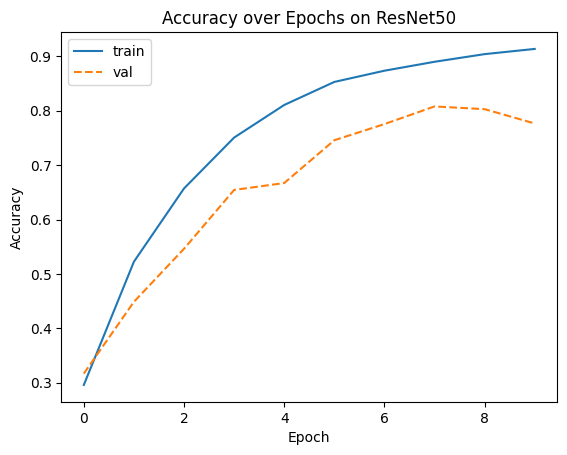

In [ ]:
y_true   = np.concatenate([y for _, y in test_ds], axis=0)
y_prob   = model.predict(test_ds, verbose=0)
y_pred   = np.argmax(y_prob, axis=1)

# Precision / Recall / F1
target_names = [f'class {i}' for i in range(NUM_CLASSES)]
print(classification_report(y_true, y_pred,
                            target_names=target_names,
                            digits=3))

# optional: store dict for later logging
report_dict = classification_report(y_true, y_pred, output_dict=True)


# ── 4.  Training curves
plt.plot(history.history['accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs on ResNet50')
plt.plot(history.history['val_accuracy'], linestyle='--')
plt.legend(['train','val'])
plt.show()

Model- Custom CNN

In [ ]:
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import (
    InputLayer,
    Conv2D, BatchNormalization, MaxPooling2D,
    Flatten, Dense, Dropout
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def build_custom_cnn(input_shape=(32,32,3), num_classes=NUM_CLASSES):
    return Sequential([
        InputLayer(input_shape=input_shape),

        Conv2D(
            32, 3, activation="relu", padding="same",
            kernel_regularizer=regularizers.l2(1e-4)
        ),
        BatchNormalization(),
        MaxPooling2D(),

        Conv2D(
            64, 3, activation="relu", padding="same",
            kernel_regularizer=regularizers.l2(1e-4)
        ),
        BatchNormalization(),
        MaxPooling2D(),

        Conv2D(
            128, 3, activation="relu", padding="same",
            kernel_regularizer=regularizers.l2(1e-4)
        ),
        BatchNormalization(),
        MaxPooling2D(),

        Flatten(),
        Dense(
            256, activation="relu",
            kernel_regularizer=regularizers.l2(1e-4)
        ),
        Dropout(0.5),
        Dense(num_classes, activation="softmax")
    ], name="custom_cnn")

# Instantiate
custom_model = build_custom_cnn()

# Callbacks
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=4,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=2,
        min_lr=1e-6
    )
]

# Compile
custom_model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Train (assuming train_ds already applies your external augmentations)
history_custom = custom_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=callbacks
)

# Evaluate
test_loss, test_acc = custom_model.evaluate(test_ds, verbose=0)
print(f"Custom CNN Test Accuracy: {test_acc * 100:.2f}%")



Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


544/544 ━━━━━━━━━━━━━━━━━━━━ 50s 80ms/step - accuracy: 0.3383 - loss: 2.5921 - val_accuracy: 0.4370 - val_loss: 2.0795 - learning_rate: 0.0010
Epoch 2/15
544/544 ━━━━━━━━━━━━━━━━━━━━ 46s 85ms/step - accuracy: 0.5707 - loss: 1.4195 - val_accuracy: 0.6485 - val_loss: 1.1551 - learning_rate: 0.0010
Epoch 3/15
544/544 ━━━━━━━━━━━━━━━━━━━━ 39s 71ms/step - accuracy: 0.7227 - loss: 0.9316 - val_accuracy: 0.6757 - val_loss: 1.1463 - learning_rate: 0.0010
Epoch 4/15
544/544 ━━━━━━━━━━━━━━━━━━━━ 39s 71ms/step - accuracy: 0.8029 - loss: 0.6900 - val_accuracy: 0.7395 - val_loss: 0.9562 - learning_rate: 0.0010
Epoch 5/15
544/544 ━━━━━━━━━━━━━━━━━━━━ 38s 71ms/step - accuracy: 0.8434 - loss: 0.5777 - val_accuracy: 0.7041 - val_loss: 1.1051 - learning_rate: 0.0010
Epoch 6/15
544/544 ━━━━━━━━━━━━━━━━━━━━ 39s 71ms/step - accuracy: 0.8660 - loss: 0.5234 - val_accuracy: 0.7814 - val_loss: 0.9115 - learning_rate: 0.0010
Epoch 7/15
544/544 ━━━━━━━━━━━━━━━━━━━━ 41s 72ms/step - accuracy: 0.8858 - loss: 0.4715

In [ ]:
custom_model = build_custom_cnn()
custom_model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# print the architecture
custom_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "custom_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 629,739 (2.40 MB)

 Trainable params: 629,291 (2.40 MB)

 Non-trainable params: 448 (1.75 KB)

              precision    recall  f1-score   support

     class 0      0.788     0.683     0.732        60
     class 1      0.666     0.985     0.794       720
     class 2      0.922     0.519     0.664       750
     class 3      0.852     0.858     0.855       450
     class 4      0.915     0.948     0.932       660
     class 5      0.615     0.840     0.710       630
     class 6      0.929     0.960     0.944       150
     class 7      0.854     0.558     0.675       450
     class 8      0.910     0.742     0.818       450
     class 9      0.948     0.992     0.969       480
    class 10      0.998     0.953     0.975       660
    class 11      0.937     0.919     0.928       420
    class 12      0.985     0.938     0.961       690
    class 13      0.961     0.986     0.973       720
    class 14      0.982     1.000     0.991       270
    class 15      0.995     0.990     0.993       210
    class 16      1.000     1.000     1.000       150
    class 17      1.000    

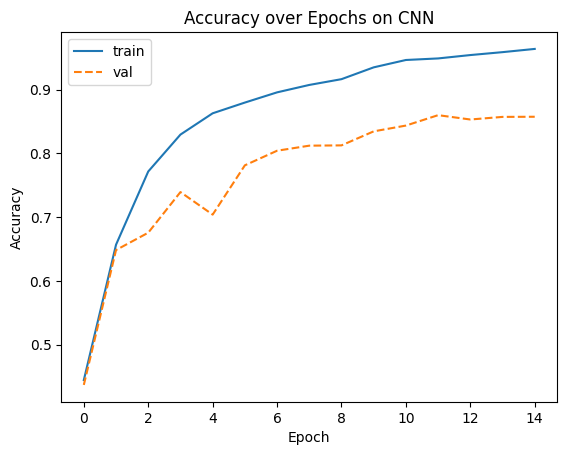

In [ ]:
y_true   = np.concatenate([y for _, y in test_ds], axis=0)
y_prob   = custom_model.predict(test_ds, verbose=0)
y_pred   = np.argmax(y_prob, axis=1)

# ── 2.  Precision / Recall / F1  ─────────────────────────────────────
target_names = [f'class {i}' for i in range(NUM_CLASSES)]
print(classification_report(y_true, y_pred,
                            target_names=target_names,
                            digits=3))


# ── 3.  Training curves ──────────────────────────────────────────────

# 2. Plot just the training accuracy
import matplotlib.pyplot as plt

plt.plot(history_custom.history['accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs on CNN')
plt.plot(history_custom.history['val_accuracy'], linestyle='--')
plt.legend(['train','val'])
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop

INPUT_SHAPE     = (32, 32, 3)
NUMBER_OF_CLASSES = NUM_CLASSES

model = Sequential()

# 1st conv block
model.add(Conv2D(
    filters=128,
    kernel_size=(4,4),
    padding="same",
    activation="relu",
    input_shape=INPUT_SHAPE
))
model.add(MaxPooling2D(pool_size=(2,2)))

# 2nd conv block
model.add(Conv2D(
    filters=64,
    kernel_size=(4,4),
    padding="same",
    activation="relu"
))
model.add(MaxPooling2D(pool_size=(2,2)))

# 3rd conv block
model.add(Conv2D(
    filters=32,
    kernel_size=(4,4),
    padding="same",
    activation="relu"
))
model.add(MaxPooling2D(pool_size=(2,2)))

# 4th conv block
model.add(Conv2D(
    filters=16,
    kernel_size=(4,4),
    padding="same",
    activation="relu"
))
model.add(MaxPooling2D(pool_size=(2,2)))

# classifier head
model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=NUMBER_OF_CLASSES, activation="softmax"))

# compile
model.compile(
    optimizer=RMSprop(),
    loss="sparse_categorical_crossentropy",   # or "categorical_crossentropy" if your labels are one-hot
    metrics=["accuracy"]
)

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 32, 32, 128)    │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 16, 16, 64)     │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 8, 8, 32)       │        32,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 4, 4, 16)       │         8,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 2, 2, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 512)            │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 43)             │        22,059 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 233,755 (913.11 KB)

 Trainable params: 233,755 (913.11 KB)

 Non-trainable params: 0 (0.00 B)

              precision    recall  f1-score   support

     class 0      0.400     0.133     0.200        60
     class 1      0.943     0.685     0.793       720
     class 2      0.427     0.975     0.594       750
     class 3      0.962     0.398     0.563       450
     class 4      0.886     0.945     0.915       660
     class 5      0.704     0.178     0.284       630
     class 6      0.639     0.860     0.733       150
     class 7      0.933     0.676     0.784       450
     class 8      0.731     0.936     0.821       450
     class 9      0.998     0.935     0.966       480
    class 10      0.954     0.985     0.969       660
    class 11      0.976     0.855     0.911       420
    class 12      0.957     0.961     0.959       690
    class 13      0.973     0.994     0.984       720
    class 14      1.000     0.996     0.998       270
    class 15      0.986     0.986     0.986       210
    class 16      0.993     0.947     0.969       150
    class 17      0.994    

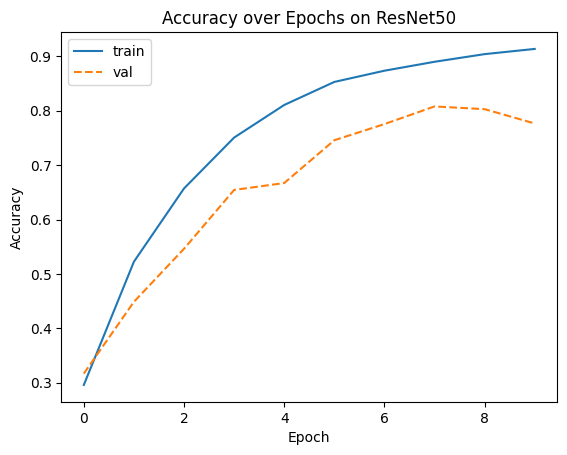

In [ ]:
# if test_ds is batched (tf.data), flatten the batches
y_true   = np.concatenate([y for _, y in test_ds], axis=0)
y_prob   = model.predict(test_ds, verbose=0)
y_pred   = np.argmax(y_prob, axis=1)

# Precision / Recall / F1
target_names = [f'class {i}' for i in range(NUM_CLASSES)]
print(classification_report(y_true, y_pred,
                            target_names=target_names,
                            digits=3))

report_dict = classification_report(y_true, y_pred, output_dict=True)


# Training curves
plt.plot(history.history['accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs on ResNet50')
plt.plot(history.history['val_accuracy'], linestyle='--')
plt.legend(['train','val'])
plt.show()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define callbacks
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=3,                 # stop if val_loss doesn't improve for 3 epochs
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,                 # cut LR in half
        patience=2,                 # if no improvement for 2 epochs
        min_lr=1e-6
    )
]

#Train for 10 epochs with callbacks
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)

#Evaluate on test set
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"Test accuracy: {test_acc * 100:.2f}%")


Epoch 1/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 51s 85ms/step - accuracy: 0.2055 - loss: 2.8419 - val_accuracy: 0.3168 - val_loss: 2.3340 - learning_rate: 0.0010
Epoch 2/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 42s 78ms/step - accuracy: 0.4271 - loss: 1.7831 - val_accuracy: 0.4488 - val_loss: 1.7774 - learning_rate: 0.0010
Epoch 3/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 44s 81ms/step - accuracy: 0.5953 - loss: 1.1752 - val_accuracy: 0.5463 - val_loss: 1.3997 - learning_rate: 0.0010
Epoch 4/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 43s 78ms/step - accuracy: 0.7154 - loss: 0.8268 - val_accuracy: 0.6544 - val_loss: 1.1408 - learning_rate: 0.0010
Epoch 5/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 82s 77ms/step - accuracy: 0.7906 - loss: 0.6125 - val_accuracy: 0.6671 - val_loss: 1.2415 - learning_rate: 0.0010
Epoch 6/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 81s 76ms/step - accuracy: 0.8431 - loss: 0.4674 - val_accuracy: 0.7458 - val_loss: 0.9214 - learning_rate: 0.0010
Epoch 7/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 42s 78ms/step - accuracy: 0.8712 - l